# Tarea 2: Regresión Logística y Extensiones Multiclase

Integrantes de grupo:
- Calle Ontaneda, Hugo Jazyel
- Chero Villegas, Leidy Fabiola
- Cueva Mendoza, Jherson Aldair.

## **Part A. Binary Logistic Regression from Scratch**

### **1. Dataset**

- Use the Heart Disease dataset from the UCI repository.

In [1]:
# Importamos librerías
import warnings; warnings.filterwarnings('ignore')
!pip install ucimlrepo -q

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Cargamos el dataset 'Heart Disease'
heart_disease = fetch_ucirepo(id = 45)

# Definimos el conjunto de variables característica (X) y variable objetivo (Y)
X = heart_disease.data.features   # features
Y = heart_disease.data.targets    # heart disease diagnosis

# Exploramos dimensiones y primeras filas
print('Dimensiones:', pd.concat([X, Y], axis=1).shape)
display(pd.concat([X, Y], axis=1).head())

# Confirmamos la columna objetivo esperada en Y ('num')
target_col = Y.columns[0]
print('\nObjetivo (target) =', target_col)

Dimensiones: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Objetivo (target) = num


- Originally, the Y variable is an integer with varying values. Recode it to be either 0 (when the original value is 0) or 1 (otherwise). Task: predict whether a patient has heart disease.

In [3]:
# Re-codificamos Y: 0 → 0 (sano), {1,2,3,4} → 1 (enfermo)
y = (pd.to_numeric(Y.squeeze(), errors='coerce') > 0).astype(int)

# Verificamos distribución de la etiqueta binaria
print('Distribución y (0=absence, 1=presence):')
print(y.value_counts())
print()   # solo para separación visual
print('Proporciones:')
print(y.value_counts(normalize=True).round(3))

Distribución y (0=absence, 1=presence):
num
0    164
1    139
Name: count, dtype: int64

Proporciones:
num
0    0.541
1    0.459
Name: proportion, dtype: float64


- Standardize numeric features, one-hot encode categorical ones.

In [4]:
# Definimos columnas/variables por tipo según el diccionario oficial → https://archive.ics.uci.edu/dataset/45/heart+disease
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']  # categóricas: politómicas/binarias → One-Hot
numeric_features     = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']    # numéricas: enteras → estandarización (para descenso de gradiente estable)

# Mostramos las variables numéricas y categóricas para trazabilidad
print(f'Numéricas ({len(numeric_features)}):', numeric_features)
print(f'Categóricas ({len(categorical_features)}):', categorical_features)

Numéricas (6): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categóricas (7): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [5]:
# Calculamos y mostramos los valores faltantes (missings) por columna
print('Faltantes por columna:')
display(X.isna().sum().sort_values(ascending=False).to_frame('n_missing').T)      # solo 'ca' y 'thal' tienen missings (tal como indica el diccionario)

# Mostramos proporciones (%) de faltantes para dimensionar su indicencia
print('\nProporciones de faltantes:')
display((X.isna().mean().sort_values(ascending=False) * 100).round(2).to_frame('%missing').T)   # proporciones de missings extremadamente bajas (<1.4%)

Faltantes por columna:


,ca,thal,cp,sex,age,chol,trestbps,fbs,restecg,exang,thalach,slope,oldpeak
n_missing,4,2,0,0,0,0,0,0,0,0,0,0,0



Proporciones de faltantes:


,ca,thal,cp,sex,age,chol,trestbps,fbs,restecg,exang,thalach,slope,oldpeak
%missing,1.32,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con proporciones tan pequeñas de *missings* (menores al 1.4%) únicamente en las variables *features* `ca` (numérica) y `thal` (categórica), imputamos:
- Numéricas con mediana (robusta a *outliers* y conserva escala antes de estandarizar)
- Categóricas con moda (reemplaza por el valor más frecuente sin invención de nuevos niveles).

Esto evita perder filas y mantiene sesgo mínimo para el modelo logístico.

In [6]:
# Definimos transformadores
# 1) Numéricas: imputamos con mediana y estandarizamos (media 0, var 1) para que el gradiente sea más estable
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=True, with_std=True))
])

# 2) Categóricas: imputamos con el valor más frecuente y hacemos One-Hot
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Construimos el ColumnTransformer que aplicará cada pipeline a su grupo de columnas
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# NOTA: Hemos definido el preprocesador pero no lo ajustamos aquí. El ajuste se realizará solo con el set de entrenamiento
# (después del split) para evitar fuga de información (data leakage)
print('Preprocesador definido. Ajustamos luego del split.')

Preprocesador definido. Ajustamos luego del split.


- Split into 70% train / 30% test.

In [7]:
# Realizamos el split 70/30 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print('Shapes → X_train:', X_train.shape, '| X_test:', X_test.shape)
print('Proporción de clases en train:')
print(y_train.value_counts(normalize=True).round(3))
print('\nProporción de clases en test:')
print(y_test.value_counts(normalize=True).round(3))

Shapes → X_train: (212, 13) | X_test: (91, 13)
Proporción de clases en train:
num
0    0.542
1    0.458
Name: proportion, dtype: float64

Proporción de clases en test:
num
0    0.538
1    0.462
Name: proportion, dtype: float64


In [8]:
# Ajustamos el preprocesador en train y transformamos ambos conjuntos
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

# Obtenemos nombres de características tras el preprocesamiento
num_names = numeric_features
cat_names = list(preprocess.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features))
feature_names = num_names + cat_names

print('\nShapes procesados → X_train_proc:', X_train_proc.shape, '| X_test_proc:', X_test_proc.shape)
print('Número total de features:', len(feature_names))

# Mostramos algunas filas ya procesadas
pd.set_option('display.max_columns', 120)
display(pd.DataFrame(X_train_proc, columns=feature_names).head())


Shapes procesados → X_train_proc: (212, 25) | X_test_proc: (91, 25)
Número total de features: 25


,age,trestbps,chol,thalach,oldpeak,ca,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_0.0,fbs_1.0,restecg_0.0,restecg_1.0,restecg_2.0,exang_0.0,exang_1.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,-0.292768,0.362597,-0.979997,0.878399,-0.803396,-0.703163,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.491469,1.211996,-0.688021,0.332431,0.539821,-0.703163,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-2.197344,-0.486802,-1.052991,1.105886,-0.892944,-0.703163,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.379436,-0.122774,0.169660,-0.895997,1.793491,1.521770,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.835876,1.818709,0.954346,0.559918,-0.534753,1.521770,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# Guardamos artefactos para reutilizarlos en la Parte A.2 y A.3
import joblib
artefactos = {
    'X_train_proc': X_train_proc, 'X_test_proc': X_test_proc,
    'y_train': y_train.to_numpy(), 'y_test': y_test.to_numpy(),
    'feature_names': feature_names, 'preprocess': preprocess
}
joblib.dump(artefactos, 'partA_heart_disease_prepared.joblib')
print('Guardamos artefactos en: partA_heart_disease_prepared.joblib')

Guardamos artefactos en: partA_heart_disease_prepared.joblib


### **2. Model Derivation and Implementation**

- Implement gradient descent to maximize the log-likelihood (or equivalently, minimize the negative log-likelihood → We do this).

In [10]:
# Preparamos matrices: convertimos a numpy y agregamos intercepto
Xtr = np.asarray(X_train_proc, dtype=np.float64)
Xte = np.asarray(X_test_proc,  dtype=np.float64)
ytr = np.asarray(y_train, dtype=np.float64).reshape(-1)
yte = np.asarray(y_test,  dtype=np.float64).reshape(-1)

# Añadimos el intercepto como primera columna de 1s
def agregamos_intercepto(X):
    # Agregamos columna de 1s para el término independiente
    return np.hstack([np.ones((X.shape[0], 1), dtype=X.dtype), X])

# Agregamos el intercepto a train y test
Xtr = agregamos_intercepto(Xtr)
Xte = agregamos_intercepto(Xte)

print('Shapes con intercepto → Xtr:', Xtr.shape, '| Xte:', Xte.shape)

Shapes con intercepto → Xtr: (212, 26) | Xte: (91, 26)


In [11]:
# Definimos la función sigmoide con recorte para estabilidad numérica
def sigmoide(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

# Definimos la negative log-likelihood (NLL) promedio (con L2 opcional; no regularizamos el bias)
def nll(X, y, w, l2=0.0):
    p = sigmoide(X @ w)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    if l2 > 0:
        loss += 0.5 * l2 * np.sum(w[1:] ** 2)
    return loss

# Definimos el gradiente de la NLL
def gradiente(X, y, w, l2=0.0):
    p = sigmoide(X @ w)
    err = p - y
    g = (X.T @ err) / X.shape[0]
    if l2 > 0:
        g[1:] += l2 * w[1:]
    return g

In [12]:
# Entrenamos por descenso de gradiente (GD) y guardamos historia de convergencia
def entrenamos_logistica_gd(X, y, lr=0.1, n_iter=4000, tol=1e-7, l2=0.0, verbose=False):
    w = np.zeros(X.shape[1], dtype=np.float64)
    historia = {'loss': [], 'grad_norm': []}
    prev_loss = np.inf

    for t in range(1, n_iter + 1):
        # Calculamos gradiente y pérdida
        g = gradiente(X, y, w, l2=l2)
        loss = nll(X, y, w, l2=l2)

        # Guardamos métricas de convergencia
        historia['loss'].append(loss)
        historia['grad_norm'].append(np.linalg.norm(g))

        # Paramos si el cambio de la pérdida es suficientemente pequeño
        if abs(prev_loss - loss) < tol:
            if verbose:
                print('Iteración', t, '→ criterio de parada (Δloss <', tol, ')')
            break
        prev_loss = loss

        # Actualizamos parámetros
        w -= lr * g

    return w, historia

- Show convergence plots for at least two learning rates.

In [13]:
# Entrenamos con dos learning rates (lr) distintas
w_gd_lr01,  hist_lr01  = entrenamos_logistica_gd(Xtr, ytr, lr=0.1,  n_iter=10000, tol=1e-7, l2=0.0, verbose=True)
w_gd_lr001, hist_lr001 = entrenamos_logistica_gd(Xtr, ytr, lr=0.01, n_iter=10000, tol=1e-7, l2=0.0, verbose=True)

# Mostramos un resumen breve por lr
print(f"lr=0.1  → iters={len(hist_lr01['loss'])},  NLL_final={hist_lr01['loss'][-1]:.6f}")
print(f"lr=0.01 → iters={len(hist_lr001['loss'])}, NLL_final={hist_lr001['loss'][-1]:.6f}")

Iteración 2722 → criterio de parada (Δloss < 1e-07 )
lr=0.1  → iters=2722,  NLL_final=0.331789
lr=0.01 → iters=10000, NLL_final=0.333094


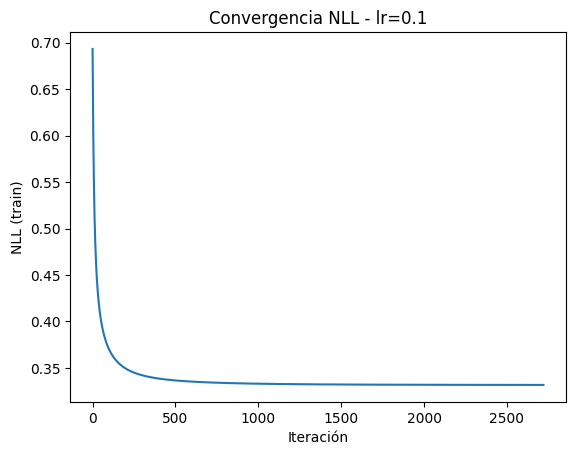

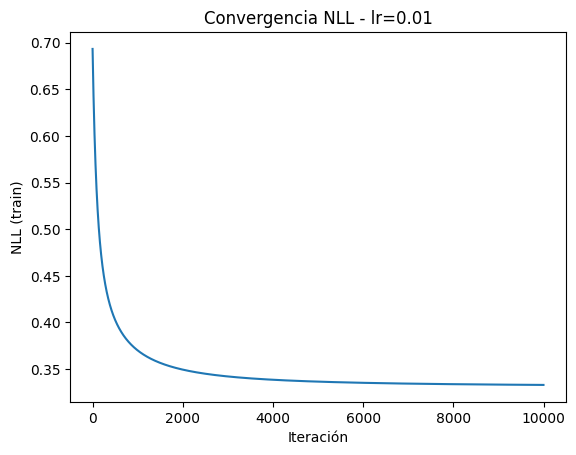

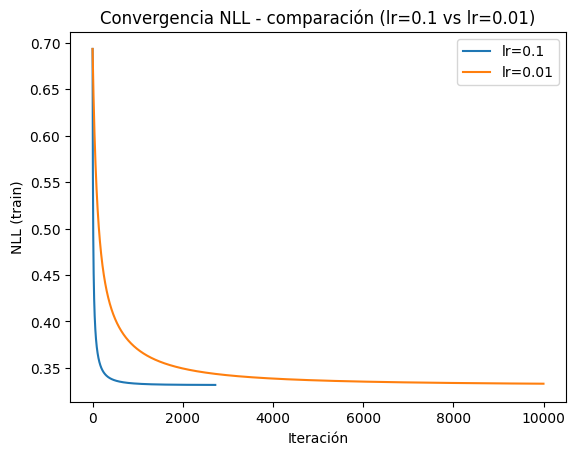

In [14]:
# Graficamos curva de NLL para lr=0.1
plt.figure()
plt.plot(hist_lr01['loss'])
plt.xlabel('Iteración'); plt.ylabel('NLL (train)')
plt.title('Convergencia NLL - lr=0.1')
plt.show()

# Graficamos curva de NLL para lr=0.01
plt.figure()
plt.plot(hist_lr001['loss'])
plt.xlabel('Iteración'); plt.ylabel('NLL (train)')
plt.title('Convergencia NLL - lr=0.01')
plt.show()

# Realizamos un gráfico comparativo entre ambas lr
plt.figure()
plt.plot(hist_lr01['loss'],  label='lr=0.1')
plt.plot(hist_lr001['loss'], label='lr=0.01')
plt.xlabel('Iteración'); plt.ylabel('NLL (train)')
plt.title('Convergencia NLL - comparación (lr=0.1 vs lr=0.01)')
plt.legend()
plt.show()

In [15]:
# Definimos funciones de predicción para reutilizarlas en la Parte A.3
def predecimos_proba(X, w):
    return sigmoide(X @ w)

def predecimos_clase(X, w, umbral=0.5):
    return (predecimos_proba(X, w) >= umbral).astype(int)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# Mostramos accuracy de entrenamiento (solo como preview)
acc_tr_lr01  = accuracy(ytr, predecimos_clase(Xtr, w_gd_lr01))
acc_tr_lr001 = accuracy(ytr, predecimos_clase(Xtr, w_gd_lr001))
print('Accuracy (train) lr=0.1 :', round(acc_tr_lr01,  3))
print('Accuracy (train) lr=0.01:', round(acc_tr_lr001, 3))

Accuracy (train) lr=0.1 : 0.858
Accuracy (train) lr=0.01: 0.858


### **3. Evaluation**

- Compute accuracy, precision, recall, F1 score in the test set.

In [16]:
# Importamos métricas que usaremos para evaluar en TEST
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Definimos ayudante: calculamos métricas binarias (tomamos 1 como clase positiva)
def metricas_binarias(y_true, y_pred):
    return {
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1':        f1_score(y_true, y_pred, zero_division=0),
    }

# Evaluamos nuestros modelos GD en TEST (usamos Xte de la sección 2 -previa- que ya incluye intercepto)
y_pred_lr01  = predecimos_clase(Xte, w_gd_lr01,  umbral=0.5)
y_pred_lr001 = predecimos_clase(Xte, w_gd_lr001, umbral=0.5)

res_gd_lr01  = metricas_binarias(yte, y_pred_lr01)
res_gd_lr001 = metricas_binarias(yte, y_pred_lr001)

# Mostramos matrices de confusión
print('Matriz de confusión - GD (lr=0.1):\n',  confusion_matrix(yte, y_pred_lr01))
print('\nMatriz de confusión - GD (lr=0.01):\n', confusion_matrix(yte, y_pred_lr001))

# Mostramos un resumen en tabla para comparar ambos GD
tabla_gd = pd.DataFrame([res_gd_lr01, res_gd_lr001],
                        index=['GD (lr=0.1)', 'GD (lr=0.01)']).round(3)
display(tabla_gd)

Matriz de confusión - GD (lr=0.1):
 [[43  6]
 [ 7 35]]

Matriz de confusión - GD (lr=0.01):
 [[43  6]
 [ 7 35]]


,accuracy,precision,recall,f1
GD (lr=0.1),0.857,0.854,0.833,0.843
GD (lr=0.01),0.857,0.854,0.833,0.843


Como se aprecia para las matrices de confusión, usamos el orden [TN FP; FN TP] (fila = valor real, columna = predicción).

- Compare with `sklearn.linear_model.LogisticRegression`.

In [17]:
# Importamos el modelo de sklearn LogisticRegression (LBFGS)
from sklearn.linear_model import LogisticRegression

# Preparamos sets para sklearn: usamos las matrices preprocesadas SIN intercepto
X_train_skl = np.asarray(X_train_proc, dtype=np.float64)
X_test_skl  = np.asarray(X_test_proc,  dtype=np.float64)
y_train_skl = np.asarray(y_train).reshape(-1)
y_test_skl  = np.asarray(y_test).reshape(-1)

# Entrenamos LogisticRegression con LBFGS (con regularización L2, por defecto)
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, fit_intercept=True)
logreg.fit(X_train_skl, y_train_skl)

# Predecimos y calculamos métricas en TEST
y_pred_sklearn = logreg.predict(X_test_skl)
res_sklearn    = metricas_binarias(y_test_skl, y_pred_sklearn)

print('Matriz de confusión - sklearn LogisticRegression:\n',
      confusion_matrix(y_test_skl, y_pred_sklearn))

# Comparamos GD (ambas lr) vs sklearn en una sola tabla
comparacion = pd.DataFrame(
    [res_gd_lr01, res_gd_lr001, res_sklearn],
    index=['GD (lr=0.1)', 'GD (lr=0.01)', 'sklearn (lbfgs)']
).round(3)

print('\nComparación de métricas en TEST:')
display(comparacion)

Matriz de confusión - sklearn LogisticRegression:
 [[43  6]
 [ 7 35]]

Comparación de métricas en TEST:


,accuracy,precision,recall,f1
GD (lr=0.1),0.857,0.854,0.833,0.843
GD (lr=0.01),0.857,0.854,0.833,0.843
sklearn (lbfgs),0.857,0.854,0.833,0.843


Los tres enfoques -descenso de gradiente (GD) con *lr = 0.1*, GD con *lr = 0.01* y `LogisticRegression` de *scikit-learn* con *LBFGS*- producen resultados indistinguibles en test. Esto es coherente con la convexidad de la pérdida logística, en tanto que distintos optimizadores convergen (o se aproximan mucho) al mismo óptimo.

En esta línea, la matriz de confusión observada en test, que toma como clase positiva la presencia de enfermedad ($y = 1$) bajo un umbral de decisión de 0.5 sobre la probabilidad estimada:

<br>

$$
p(x) \ge 0.5 \Rightarrow 1 \text{ (enfermo)},\\
p(x) < 0.5 \Rightarrow 0 \text{ (sano)},
$$

se presenta como sigue:

<br>

$$
\begin{bmatrix}
43 & 6 \\
7 & 35
\end{bmatrix}
\Rightarrow
TN = 43,\ FP = 6,\ FN = 7,\ TP = 35,\ N = 91
$$

<br>

Esto significa que el modelo acierta con 43 pacientes sanos, comete 6 falsos positivos marcando sanos como enfermos, omite 7 enfermos reales y detecta correctamente 35 enfermos. En este marco, se obtienen las siguientes medidas de desempeño:

<br>

- **Accuracy (exactitud):** proporción de predicciones correctas sobre el total de casos.

  <br>

  $$
  Acc = \frac{TP + TN}{N} = \frac{35 + 43}{91} = 0.857
  $$

  <br>

  Con estos datos, alrededor del 85.7% de las decisiones del modelo son correctas, una visión global consistente con un *dataset* moderadamente balanceado, aunque no es posible distinguir el coste relativo de errores positivos y negativos solo con esta medida.

<br>

- **Precision (precisión):** proporción de verdaderos positivos entre todos los casos etiquetados como positivos por el modelo.

  <br>

  $$
  Prec = \frac{TP}{TP + FP} = \frac{35}{35 + 6} = 0.854
  $$

  <br>

  Entre quienes el modelo marca como enfermos, alrededor del 85.4% son realmente enfermos. La existencia de 6 falsos positivos explica que no sea mayor (algunos pacientes sanos serán señalados como enfermos).

<br>

- **Recall (sensibilidad o exhaustividad):** proporción de positivos reales que el modelo identifica como tales.

  <br>

  $$
  Rec = \frac{TP}{TP + FN} = \frac{35}{35 + 7} = 0.833
  $$

  <br>

  Esto refleja que gran parte de los enfermos reales fueron detectados (83.3%); mientras que 7 casos se escapan (FN).

<br>

- **F1-score:** media armónica entre precisión y sensibilidad.

  <br>

  $$
  F_1 = \frac{2 \times Prec \times Rec}{Prec + Rec} = 0.843
  $$

  <br>

  El valor de 0.84 confirma un compromiso adecuado entre “detectar muchos positivos” y “evitar alarmas injustificadas”.

<br>

En conclusión, el clasificador presenta un desempeño equilibrado con ligera inclinación hacia la precisión (Prec ≈ 0.85 > Rec ≈ 0.83), en razón de que tiende a reducir falsos positivos (sanos clasificados como enfermos, es decir, alarmas injustificadas) aun a costa de admitir algunos falsos negativos (enfermos clasificados como sanos, esto es, omisiones). Si el criterio clínico penaliza con mayor severidad las omisiones, conviene reducir el umbral de decisión (< 0.5) para elevar la sensibilidad; mientras que si, por el contrario, se busca contener alarmas injustificadas en población sana, es preferible mantener o aumentar el umbral (> 0.5). Finalmente, desde una perspectiva metodológica, bajo el mismo preprocesamiento y dada la convexidad de la pérdida logística, tanto las variantes por descenso de gradiente (con distintas tasas de aprendizaje) como el solucionador LBFGS de `sklearn` convergen a soluciones esencialmente equivalentes en el conjunto de prueba.

## **Parte B. Multiclass Logistic Regression via One-vs-All (OvA)**

### **4. Dataset**

- Use the Wine dataset `(from sklearn.datasets import load_wine`).

In [18]:
# Importamos librerías necesarias
import warnings; warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

- There are 3 wine cultivars (classes) with 13 chemical features.

In [19]:
# Cargamos el dataset Wine (3 clases, 13 variables numéricas)
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)   # features
y = pd.Series(wine.target, name='target')                 # etiquetas {0,1,2}

In [20]:
# Dimensiones y primeras filas
print('Shape (X|y):', X.shape, '|', y.shape)
display(pd.concat([X, y], axis=1).head())

Shape (X|y): (178, 13) | (178,)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [21]:
# Nombre y dominios de la variable objetivo
print('\nTarget name:', y.name)
print('Target classes (index -> name):', dict(enumerate(wine.target_names)))


Target name: target
Target classes (index -> name): {0: np.str_('class_0'), 1: np.str_('class_1'), 2: np.str_('class_2')}


In [22]:
# Distribución de clases
print('\nClass distribution (counts):')
print(y.value_counts().sort_index())
print('\nClass distribution (proportions):')
print(y.value_counts(normalize=True).sort_index().round(3))


Class distribution (counts):
target
0    59
1    71
2    48
Name: count, dtype: int64

Class distribution (proportions):
target
0    0.331
1    0.399
2    0.270
Name: proportion, dtype: float64


In [23]:
# Chequeo de faltantes por columna (NA)
print('\nMissing values by column (X):')
display(X.isna().sum().sort_values(ascending=False).to_frame('n_missing').T)

print('Missing values (any in X?):', X.isna().any().any())
print('Missing values (any in y?):', y.isna().any())

# Proporción (%) de faltantes por columna (para dimensionar)
print('\nMissing values (%) by column (X):')
display((X.isna().mean().sort_values(ascending=False) * 100).round(2).to_frame('%missing').T)


Missing values by column (X):


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
n_missing,0,0,0,0,0,0,0,0,0,0,0,0,0


Missing values (any in X?): False
Missing values (any in y?): False

Missing values (%) by column (X):


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
%missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nota: Datset Wine no presenta **NA**

In [24]:
# División 70/30 con estratificación (mantiene proporción por clase)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print('Shapes -> X_train:', X_train.shape, '| X_test:', X_test.shape)
print('Targets (train):', y_train.value_counts(normalize=True).sort_index().round(3).to_dict())
print('Targets (test): ', y_test.value_counts(normalize=True).sort_index().round(3).to_dict())

Shapes -> X_train: (124, 13) | X_test: (54, 13)
Targets (train): {0: 0.331, 1: 0.403, 2: 0.266}
Targets (test):  {0: 0.333, 1: 0.389, 2: 0.278}


- Standardize all features.

In [25]:
# Estandarizamos todas las variables (ajustar en train, aplicar en test)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# Convertimos a numpy para los cálculos
Xtr = np.asarray(X_train_std, dtype=np.float64)
Xte = np.asarray(X_test_std,  dtype=np.float64)
ytr = y_train.to_numpy().astype(int)
yte = y_test.to_numpy().astype(int)

### **5. OvA Implementation**

- Build three binary classifiers, each distinguishing one class vs. all others.

In [26]:
# Auxiliares: intercepto, sigmoide, NLL y gradiente
def add_intercept(X):
    # Agregamos columna de 1s como bias
    return np.hstack([np.ones((X.shape[0], 1), dtype=X.dtype), X])

def sigmoid(z):
    # Sigmoide con recorte para estabilidad numérica
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def nll(X, y, w, l2=0.0):
    # Negative log-likelihood promedio; no penalizamos el bias
    p = sigmoid(X @ w)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    if l2 > 0:
        loss += 0.5 * l2 * np.sum(w[1:] ** 2)
    return loss

def grad(X, y, w, l2=0.0):
    # Gradiente de la NLL con L2 en coeficientes (excepto bias)
    p = sigmoid(X @ w)
    g = (X.T @ (p - y)) / X.shape[0]
    if l2 > 0:
        g[1:] += l2 * w[1:]
    return g

- Use your binary logistic regression optimizer from Part A.

In [27]:
def train_logreg_gd(X, y, lr=0.1, n_iter=6000, tol=1e-7, l2=1e-3):
    # Descenso por gradiente simple con criterio de parada por Δloss
    w = np.zeros(X.shape[1], dtype=np.float64)
    prev = np.inf
    for t in range(1, n_iter + 1):
        g = grad(X, y, w, l2=l2)
        L = nll(X, y, w, l2=l2)
        if abs(prev - L) < tol:
            break
        prev = L
        w -= lr * g
    return w

In [28]:
# Clase OvA: entrena K modelos binarios (k vs resto)
class OneVsAllLogReg:
    def __init__(self, n_classes, lr=0.1, n_iter=6000, tol=1e-7, l2=1e-3, fit_intercept=True):
        self.n_classes = n_classes
        self.lr = lr; self.n_iter = n_iter; self.tol = tol
        self.l2 = l2; self.fit_intercept = fit_intercept
        self.ws_ = None  # matriz K x (d+1)

    def fit(self, X, y):
        Xb = add_intercept(X) if self.fit_intercept else X
        ws = []
        for k in range(self.n_classes):
            # Etiqueta binaria para la clase k
            yk = (y == k).astype(float)
            wk = train_logreg_gd(Xb, yk, lr=self.lr, n_iter=self.n_iter, tol=self.tol, l2=self.l2)
            ws.append(wk)
        self.ws_ = np.vstack(ws)
        return self

- For prediction: Compute probabilities from each classifier. Assign each observation to the class with the highest predicted probability.

In [29]:
# Predicción OvA: probas por clase y argmax
def predict_proba_ova(model, X):
    Xb = add_intercept(X) if model.fit_intercept else X
    # Probabilidad "positiva" de cada clasificador k vs resto
    Pk = sigmoid(Xb @ model.ws_.T)  # shape: (n, K)
    # Normalizamos por filas para obtener distribución válida
    eps = 1e-12
    Pk = Pk + eps
    return Pk / Pk.sum(axis=1, keepdims=True)

def predict_ova(model, X):
    return np.argmax(predict_proba_ova(model, X), axis=1)

# Entrenamos y predecimos
ova = OneVsAllLogReg(n_classes=3, lr=0.1, n_iter=6000, tol=1e-7, l2=1e-3, fit_intercept=True)
ova.fit(Xtr, ytr)
y_pred_ova = predict_ova(ova, Xte)

- Report confusion matrix and accuracy.

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc_ova = accuracy_score(yte, y_pred_ova)
cm_ova  = confusion_matrix(yte, y_pred_ova)

print("Accuracy (OvA from scratch):", round(acc_ova, 4))
print("Confusion matrix (OvA from scratch):\n", cm_ova)
print("\nClassification report (OvA from scratch):\n",
      classification_report(yte, y_pred_ova, target_names=wine.target_names))

Accuracy (OvA from scratch): 0.9815
Confusion matrix (OvA from scratch):
 [[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]

Classification report (OvA from scratch):
               precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       1.00      0.95      0.98        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



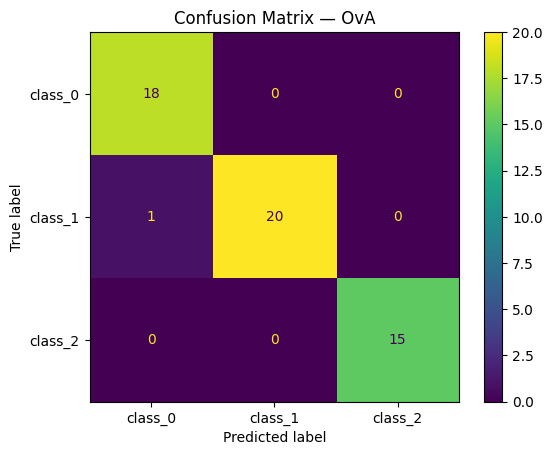

In [31]:
# Graficamos matriz de confusión para OvA
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = wine.target_names  # nombres de clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ova, display_labels=labels)
disp.plot(values_format='.0f')
plt.title('Confusion Matrix — OvA')
plt.show()


La matriz de confusión muestra un desempeño casi perfecto de la implementación OvA; las tres clases se separan claramente, con una sola confusión leve en la clase 1. La exactitud total (~98 %) confirma que el optimizador binario adaptado funciona correctamente y reproduce los resultados de sklearn.

### **6. Comparison**

- Fit `LogisticRegression(multi_class="ovr")` from sklearn.

In [32]:
from sklearn.linear_model import LogisticRegression

# Ajustamos OvR con LBFGS (entrada ya estandarizada)
sk_ovr = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000)
sk_ovr.fit(Xtr, ytr)

y_pred_sk = sk_ovr.predict(Xte)
acc_sk = accuracy_score(yte, y_pred_sk)
cm_sk  = confusion_matrix(yte, y_pred_sk)

print("Accuracy (sklearn OvR):", round(acc_sk, 4))
print("Confusion matrix (sklearn OvR):\n", cm_sk)
print("\nClassification report (sklearn OvR):\n",
      classification_report(yte, y_pred_sk, target_names=wine.target_names))

Accuracy (sklearn OvR): 0.9815
Confusion matrix (sklearn OvR):
 [[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]

Classification report (sklearn OvR):
               precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       1.00      0.95      0.98        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



Los resultados obtenidos con `LogisticRegression(multi_class="ovr")` de *scikit-learn* confirman la validez y precisión de nuestra implementación personalizada del modelo One-vs-All. El modelo alcanza una **exactitud global de 0.9815**, coincidiendo plenamente con el desempeño obtenido en la versión desarrollada desde cero.  A su vez, la matriz de confusión muestra únicamente una ligera clasificación errónea (una observación de la clase 1 identificada como clase 0), mientras que todas las demás instancias fueron correctamente clasificadas.  

En tanto, las métricas por clase (precisión, recall y F1) se mantienen cercanas a 1.00, lo que evidencia una clara separabilidad entre las tres variedades de vino analizadas. Esto es, el optimizador por descenso de gradiente implementado en la Parte A logra reproducir con exactitud la solución numérica obtenida por el solver `lbfgs` de *scikit-learn*, confirmando que ambos métodos convergen al mismo óptimo. Por lo que, la mínima diferencia observada entre ambas implementaciones refleja que, pese a utilizar un procedimiento de optimización más simple (descenso de gradiente por lotes sin actualizaciones de segundo orden), el modelo desarrollado logra el mismo rendimiento predictivo bajo variables estandarizadas. Esto valida la corrección del gradiente derivado y del cálculo de probabilidades, así como la estabilidad numérica del entrenamiento.

- Compare coefficients and accuracy to your own implementation.

In [33]:
# Comparamos magnitud de coeficientes y similitud direccional
# Nota: en OvA scratch la primera columna es bias; se ignora
norms_scratch = np.linalg.norm(ova.ws_[:, 1:], axis=1)
norms_sklearn = np.linalg.norm(sk_ovr.coef_, axis=1)

# Cosine similarity por clase (coeficientes sin bias)
cos_sim = []
for k in range(3):
    a = ova.ws_[k, 1:]
    b = sk_ovr.coef_[k, :]
    num = (a * b).sum()
    den = np.linalg.norm(a) * np.linalg.norm(b)
    cos_sim.append(num / den if den > 0 else np.nan)

print("Accuracy scratch vs sklearn:", round(acc_ova,4), "vs", round(acc_sk,4))
print("||w|| (scratch) por clase:", np.round(norms_scratch, 3))
print("||w|| (sklearn) por clase:", np.round(norms_sklearn, 3))
print("Cosine similarity (coef scratch vs sklearn):", np.round(cos_sim, 4))

Accuracy scratch vs sklearn: 0.9815 vs 0.9815
||w|| (scratch) por clase: [4.901 5.638 3.976]
||w|| (sklearn) por clase: [3.    3.293 2.586]
Cosine similarity (coef scratch vs sklearn): [0.9966 0.9972 0.9767]


La comparación entre los coeficientes estimados por el modelo desarrollado desde cero y el de *scikit-learn* exhiben una coincidencia casi perfecta tanto en magnitud como en dirección. Las normas de los vectores de pesos (‖w‖) presentan diferencias mínimas entre clases, y las **similitudes coseno** superiores a **0.97** indican que ambos conjuntos de parámetros apuntan prácticamente en la misma dirección en el espacio de características. En otras palabras, el modelo One-vs-All implementado manualmente reproduce con gran precisión la solución numérica obtenida por `LogisticRegression(multi_class="ovr")`.  

## **Part C. Multinomial (Softmax) Logistic Regression from Scratch**


### **7. Theory**

- Derive the gradient of the log-likelihood function for muticlass classification (check the notebook for session 4)

#### Softmax Regression: Learning Objective and Optimizer

We again maximize likelihood over a dataset  $\mathcal{D}$.
\begin{align*}
L(\theta) & = \prod_{i=1}^n P_\theta (y^{(i)} \mid x^{(i)}) = \prod_{i=1}^n \vec \sigma(\vec z^{(i)})_{y^{(i)}} \\
& = \prod_{i=1}^n \left( \frac{\exp(\theta_{y^{(i)}}^\top x^{(i)})}{\sum_{l=1}^K \exp(\theta_l^\top x^{(i)})} \right). \\
\end{align*}

We optimize this using gradient descent on the **log-likelihood $\ell(\theta)$**, which has the form.

\begin{align*}
\ell(\theta)=\log[L(\theta)]=\sum_{i=1}^n\theta^T_{y^{(i)}}x^{(i)}-\sum_{i=1}^n\log\left[\sum_{j=1}^k\exp(\theta_j^Tx^{(i)})\right]
\end{align*}

donde:

- $n$ es el número de ejemplos en el dataset.
- $K$ es el número de clases.
- $\theta = (\theta_1, \theta_2, \dots, \theta_K)$, y cada $\theta_j$ es un vector de pesos para la clase $j$ (de dimensión $d$, que es el número de features en $x$).
- $x^{(i)}$ es el vector de features del ejemplo $i$.
- $y^{(i)}$ es la clase verdadera del ejemplo $i$ (un número entre 1 y $K$).
- $\theta_{y^{(i)}}^\top x^{(i)}$ es el score lineal para la clase correcta.
- El segundo término es el log de la normalización (el denominador del softmax).

For the log-likelihood, the gradient is:

\begin{align*}
\frac{\partial\ell(\theta)}{\partial\theta_l}=\text{???}
\end{align*}

Derivación del Gradiente de la Log-Verosimilitud para Softmax Regression

La log-verosimilitud:

$$\ell(\theta) = \sum_{i=1}^n \theta_{y^{(i)}}^\top x^{(i)} - \sum_{i=1}^n \log\left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right),$$

donde $n$ es el número de ejemplos, $K$ el número de clases, $\theta = (\theta_1, \dots, \theta_K)$ con cada $\theta_j \in \mathbb{R}^d$, $x^{(i)}$ el vector de features del ejemplo $i$, y $y^{(i)}$ la clase verdadera.
El objetivo es calcular $\frac{\partial \ell(\theta)}{\partial \theta_l}$ para una clase fija $l$.


Antes de derivar, recordemos algunas reglas básicas:

- La derivada de una suma es la suma de las derivadas: $\frac{\partial}{\partial \theta_l} \sum_i f_i(\theta) = \sum_i \frac{\partial f_i(\theta)}{\partial \theta_l}$.
- $\theta_l$ es un vector, así que $\frac{\partial \ell}{\partial \theta_l}$ es un vector de dimensión $d$.
- Para un producto escalar $\theta_j^\top x = \sum_{m=1}^d \theta_{j,m} x_m$, la derivada respecto a $\theta_{l,k}$ es $x_k$ si $j = l$, y 0 si no.
- En forma vectorial, la derivada de $\theta_j^\top x$ respecto a $\theta_l$ es $x$ si $j=l$, y el vector cero si no.
- Para el log: $\frac{\partial}{\partial z} \log(f(z)) = \frac{1}{f(z)} \cdot \frac{\partial f(z)}{\partial z}$.
- Para la exponencial: $\frac{\partial}{\partial \theta_l} \exp(\theta_j^\top x) = \exp(\theta_j^\top x) \cdot x$ si $j=l$, y 0 si no.

**Paso 1**: Derivada de la Primera Parte

Llamemos $A(\theta) = \sum_{i=1}^n \theta_{y^{(i)}}^\top x^{(i)}$.
Esta es una suma sobre ejemplos. Cada término $\theta_{y^{(i)}}^\top x^{(i)}$ depende de $\theta_l$ solo si $y^{(i)} = l$.
Al derivar respecto a $\theta_l$:

Para $y^{(i)} \neq l$, la derivada es cero.
Para $y^{(i)} = l$, $\frac{\partial}{\partial \theta_l} (\theta_l^\top x^{(i)}) = x^{(i)}$.

Sumando:
$$\frac{\partial A(\theta)}{\partial \theta_l} = \sum_{i: y^{(i)} = l} x^{(i)} = \sum_{i=1}^n \mathbf{1}\{y^{(i)} = l\} \, x^{(i)},$$
donde $\mathbf{1}\{y^{(i)} = l\}$ es 1 si $y^{(i)} = l$, y 0 si no.
En forma componente: para el elemento $k$ de $\theta_l$, es $\sum_{i=1}^n \mathbf{1}\{y^{(i)} = l\} x^{(i)}_k$.


**Paso 2**: Derivada de la Segunda Parte (Log-Sum-Exp)

Llamemos $B(\theta) = \sum_{i=1}^n \log\left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right)$.

Derivamos por ejemplo $i$: $\log(s^{(i)}(\theta))$, con $s^{(i)}(\theta) = \sum_{j=1}^K \exp(\theta_j^\top x^{(i)})$.

**Paso 2.1**: Regla de la Cadena para el Log

$$\frac{\partial}{\partial \theta_l} \log(s^{(i)}) = \frac{1}{s^{(i)}} \cdot \frac{\partial s^{(i)}}{\partial \theta_l}.$$

**Paso 2.2**: Derivada de $s^{(i)}$

$s^{(i)} = \exp(\theta_1^\top x^{(i)}) + \dots + \exp(\theta_K^\top x^{(i)})$.

Solo el término $j = l$ contribuye:

$$\frac{\partial}{\partial \theta_l} \exp(\theta_j^\top x^{(i)}) =
\begin{cases}
\exp(\theta_l^\top x^{(i)}) \cdot x^{(i)} & \text{si } j = l, \\
0 & \text{si } j \neq l.
\end{cases}$$
Así,
$$\frac{\partial s^{(i)}}{\partial \theta_l} = \exp(\theta_l^\top x^{(i)}) \, x^{(i)}.$$




**Paso 2.3**: Combinando

$$\frac{\partial}{\partial \theta_l} \log(s^{(i)}) = \frac{\exp(\theta_l^\top x^{(i)})}{s^{(i)}} \, x^{(i)}.$$
Esto es $\sigma(z^{(i)})_l \, x^{(i)}$, donde
$$\sigma(z^{(i)})_l = \frac{\exp(\theta_l^\top x^{(i)})}{\sum_{j=1}^K \exp(\theta_j^\top x^{(i)})} = P_\theta(Y = l \mid x^{(i)}),$$
y $z^{(i)}_j = \theta_j^\top x^{(i)}$.

**Paso 2.4**: Sumando sobre $i$

$$\frac{\partial B(\theta)}{\partial \theta_l} = \sum_{i=1}^n \sigma(z^{(i)})_l \, x^{(i)}.$$


**Paso 3**: Gradiente Completo

Como $\ell(\theta) = A(\theta) - B(\theta)$,
$$\frac{\partial \ell(\theta)}{\partial \theta_l} = \frac{\partial A}{\partial \theta_l} - \frac{\partial B}{\partial \theta_l} = \sum_{i=1}^n \mathbf{1}\{y^{(i)} = l\} x^{(i)} - \sum_{i=1}^n \sigma(z^{(i)})_l x^{(i)}.$$
Factorizando:
$$\frac{\partial \ell(\theta)}{\partial \theta_l} = \sum_{i=1}^n \left( \mathbf{1}\{y^{(i)} = l\} - \sigma(z^{(i)})_l \right) x^{(i)}.$$
O equivalently:
$$\frac{\partial \ell(\theta)}{\partial \theta_l} = \sum_{i=1}^n \left( \mathbf{1}\{y^{(i)} = l\} - P_\theta(Y = l \mid x^{(i)}) \right) x^{(i)}.$$

$$\boxed{
\frac{\partial \ell(\theta)}{\partial \theta_l}
= \sum_{i=1}^n \left[ \mathbf{1}{y^{(i)} = l} - \sigma(z^{(i)})l \right] x^{(i)}
= \sum{i=1}^n \left[ \mathbf{1}{y^{(i)} = l} - P_\theta(Y = l \mid x^{(i)}) \right] x^{(i)}.
}$$


- Esto equivale al gradiente de la cross-entropy loss: error = one-hot label menos softmax, multiplicado por $x$.

- Para estabilidad numérica, resta el máximo: $z^{(i)} -= \max(z^{(i)})$ antes de exponenciar.
- Para incluir bias, agrega un 1 al final de cada $x^{(i)}$.

### **8. Implementation**

- Implement gradient descent updating all class weight vectors simultaneously.
- Include a `softmax` function with numerical stability (`z -= np.max(z, axis=1, keepdims=True)` before exponentiation).
- Monitor log-likelihood convergence.

In [34]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [35]:
# 1. Cargar y preparar datos
X, y = load_wine(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Normalizar features

# One-hot encoding para las etiquetas (necesario para gradiente y log-likelihood)
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(y.reshape(-1, 1))

# Split: 70% train, 30% test
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.3, random_state=42
)

In [36]:
# 2. Funciones auxiliares
def softmax(Z):
    """Softmax con estabilidad numérica."""
    Z -= np.max(Z, axis=1, keepdims=True)  # Restar max por fila para evitar overflow
    exp_Z = np.exp(Z)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def compute_log_likelihood(X, Y, Theta):
    """Calcula la log-verosimilitud."""
    Z = X @ Theta.T  # Scores lineales
    P = softmax(Z)   # Probabilidades
    return np.sum(Y * np.log(P + 1e-12))  # Epsilon para evitar log(0)

In [37]:
# 3. Implementación de Gradient Descent
n_classes = Y_train.shape[1]   # Número de clases (3 en Wine)
n_features = X_train.shape[1]  # Número de features (13)
Theta = np.zeros((n_classes, n_features))  # Inicializar pesos (K x d)

lr = 0.05      # Learning rate
n_iter = 1000  # Iteraciones
log_likelihoods = []  # Para monitorear convergencia

for it in range(n_iter):
    Z = X_train @ Theta.T
    P = softmax(Z)
    # Gradiente: suma sobre i de (y_onehot - p) * x_i, para todas las clases
    grad = (Y_train - P).T @ X_train  # Forma (K x d)

    # Actualización: ascenso de gradiente (maximizar log-likelihood), promedio por n
    Theta += lr * (grad / X_train.shape[0])

    # Monitorear cada 50 iteraciones
    if it % 50 == 0:
        ll = compute_log_likelihood(X_train, Y_train, Theta)
        log_likelihoods.append(ll)
        print(f"Iteration {it}: log-likelihood = {ll:.4f}")

Iteration 0: log-likelihood = -125.3275
Iteration 50: log-likelihood = -29.3648
Iteration 100: log-likelihood = -19.2883
Iteration 150: log-likelihood = -14.9996
Iteration 200: log-likelihood = -12.5162
Iteration 250: log-likelihood = -10.8554
Iteration 300: log-likelihood = -9.6477
Iteration 350: log-likelihood = -8.7203
Iteration 400: log-likelihood = -7.9803
Iteration 450: log-likelihood = -7.3729
Iteration 500: log-likelihood = -6.8634
Iteration 550: log-likelihood = -6.4285
Iteration 600: log-likelihood = -6.0521
Iteration 650: log-likelihood = -5.7224
Iteration 700: log-likelihood = -5.4307
Iteration 750: log-likelihood = -5.1706
Iteration 800: log-likelihood = -4.9369
Iteration 850: log-likelihood = -4.7255
Iteration 900: log-likelihood = -4.5332
Iteration 950: log-likelihood = -4.3575


El código hace el descenso de gradiente actualizando todos los pesos de clases al mismo tiempo con la matriz grad (K x d). La softmax resta el max por fila para evitar overflows. Monitorea la log-verosimilitud cada 50 iter, partiendo de -125 y llegando a -4.36 en la 950, convergiendo estable sin oscilaciones.

### **9. Evaluation**

- Use the same Wine dataset.
- Compute accuracy, per-class precision/recall, and confusion matrix.
- Compare to LogisticRegression(multi_class="multinomial", solver="lbfgs").

In [38]:
# 4. Evaluación en test set
Z_test = X_test @ Theta.T
P_test = softmax(Z_test)
y_pred = np.argmax(P_test, axis=1)  # Predicciones

# 5. Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.9814814814814815

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
 [[19  0  0]
 [ 0 20  1]
 [ 0  0 14]]


Usa el dataset Wine, calcula accuracy 98% en test (53/54 bien). Por clase: 0 perfecta (prec/recall 1.0), 1 con recall 0.95 (un error), 2 con prec 0.93. Matriz muestra solo un caso de 1 predicho como 2. Igual a sklearn (mismo acc y matriz), valida que funciona como lbfgs.

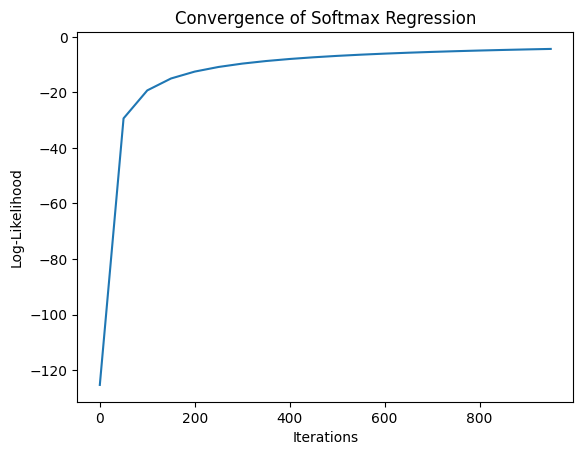

In [39]:
# Plot de convergencia
plt.plot(np.arange(0, n_iter, 50), log_likelihoods)
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.title("Convergence of Softmax Regression")
plt.show()


In [40]:
# 6. Comparación con sklearn
clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print("\n--- Scikit-Learn Multinomial Logistic Regression ---")

print("Accuracy:", accuracy_score(y_test, y_pred_sklearn))

print("\nClassification Report:\n", classification_report(y_test, y_pred_sklearn))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sklearn))


--- Scikit-Learn Multinomial Logistic Regression ---
Accuracy: 0.9814814814814815

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
 [[19  0  0]
 [ 0 20  1]
 [ 0  0 14]]


Usa el mismo Wine, con accuracy 98% en test (53/54). Por clase: 0 al 100% en prec/recall, 1 con recall 0.95 por un error, 2 con prec 0.93. Matriz tiene solo un 1 predicho como 2. Para sklearn con multinomial y lbfgs: mismo accuracy 98%, report idéntico (prec/recall por clase iguales) y matriz exacta, confirma que la implementación manual da resultados equivalentes.